In [2]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy


from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal

from functools import partial

from IPython.display import GeoJSON

from pprint import pprint

py.init_notebook_mode()

For module 2 we'll be looking at techniques for dealing with big data. In particular binning strategies and the datashader library (which possibly proves we'll never need to bin large data for visualization ever again.)

To demonstrate these concepts we'll be looking at the PLUTO dataset put out by New York City's department of city planning. PLUTO contains data about every tax lot in New York City.

PLUTO data can be downloaded from [here](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page). Unzip them to the same directory as this notebook, and you should be able to read them in using this (or very similar) code. Also take note of the data dictionary, it'll come in handy for this assignment.

In [3]:
# Code to read in v17, column names have been updated (without upper case letters) for v18

# bk = pd.read_csv('PLUTO17v1.1/BK2017V11.csv')
# bx = pd.read_csv('PLUTO17v1.1/BX2017V11.csv')
# mn = pd.read_csv('PLUTO17v1.1/MN2017V11.csv')
# qn = pd.read_csv('PLUTO17v1.1/QN2017V11.csv')
# si = pd.read_csv('PLUTO17v1.1/SI2017V11.csv')

# ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True)

ny = pd.read_csv('nyc_pluto_20v1_csv/pluto_20v1.csv')


# Getting rid of some outliers
ny = ny[(ny['yearbuilt'] > 1850) & (ny['yearbuilt'] < 2020) & (ny['numfloors'] != 0)]

/Users/josemawyin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (17,18,20,22) have mixed types. Specify dtype option on import or set low_memory=False.



In [4]:
#Showing the columns in the NY dataset
pprint(ny.columns)
ny.head(5)
ny['yearbuilt'].describe()

Index(['borough', 'block', 'lot', 'cd', 'ct2010', 'cb2010', 'schooldist',
       'council', 'zipcode', 'firecomp', 'policeprct', 'healtharea',
       'sanitboro', 'sanitsub', 'address', 'zonedist1', 'zonedist2',
       'zonedist3', 'zonedist4', 'overlay1', 'overlay2', 'spdist1', 'spdist2',
       'spdist3', 'ltdheight', 'splitzone', 'bldgclass', 'landuse',
       'easements', 'ownertype', 'ownername', 'lotarea', 'bldgarea', 'comarea',
       'resarea', 'officearea', 'retailarea', 'garagearea', 'strgearea',
       'factryarea', 'otherarea', 'areasource', 'numbldgs', 'numfloors',
       'unitsres', 'unitstotal', 'lotfront', 'lotdepth', 'bldgfront',
       'bldgdepth', 'ext', 'proxcode', 'irrlotcode', 'lottype', 'bsmtcode',
       'assessland', 'assesstot', 'exempttot', 'yearbuilt', 'yearalter1',
       'yearalter2', 'histdist', 'landmark', 'builtfar', 'residfar', 'commfar',
       'facilfar', 'borocode', 'bbl', 'condono', 'tract2010', 'xcoord',
       'ycoord', 'latitude', 'longitude', '

count    811684.000000
mean       1941.003352
std          30.440113
min        1851.000000
25%        1920.000000
50%        1931.000000
75%        1960.000000
max        2019.000000
Name: yearbuilt, dtype: float64

In [5]:
ny['numfloors'].describe()

count    811684.000000
mean          2.457334
std           1.982234
min           0.100000
25%           2.000000
50%           2.000000
75%           2.500000
max         205.000000
Name: numfloors, dtype: float64

I'll also do some prep for the geographic component of this data, which we'll be relying on for datashader.

You're not required to know how I'm retrieving the lattitude and longitude here, but for those interested: this dataset uses a flat x-y projection (assuming for a small enough area that the world is flat for easier calculations), and this needs to be projected back to traditional lattitude and longitude.

In [6]:


# wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
# nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
# ny['xcoord'] = 0.3048*ny['xcoord']
# ny['ycoord'] = 0.3048*ny['ycoord']
# ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['xcoord'].values, ny['ycoord'].values)

# ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

## Part 1: Binning and Aggregation

Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and [2D histograms](https://plot.ly/python/2D-Histogram/) (also check out their close relatives: [2D density plots](https://plot.ly/python/2d-density-plots/) and the more general form: [heatmaps](https://plot.ly/python/heatmaps/).

While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

In [7]:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('yearbuilt').count()['bbl'].index,
    y = ny.groupby('yearbuilt').count()['bbl']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Buildings Built')
)

fig = go.FigureWidget(data = [trace], layout = layout)

fig

FigureWidget({
    'data': [{'type': 'scatter',
              'uid': 'e8cf7f1c-a91e-4d14-9b37-f9f7785b384a',
 …

Something looks off... You're going to have to deal with this imperfect data to answer this first question. 

But first: some notes on pandas. Pandas dataframes are a different beast than R dataframes, here are some tips to help you get up to speed:

---

Hello all, here are some pandas tips to help you guys through this homework:

[Indexing and Selecting](https://pandas.pydata.org/pandas-docs/stable/indexing.html): .loc and .iloc are the analogs for base R subsetting, or filter() in dplyr

[Group By](https://pandas.pydata.org/pandas-docs/stable/groupby.html):  This is the pandas analog to group_by() and the appended function the analog to summarize(). Try out a few examples of this, and display the results in Jupyter. Take note of what's happening to the indexes, you'll notice that they'll become hierarchical. I personally find this more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. Once you perform an aggregation, try running the resulting hierarchical datafrome through a [reset_index()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html).

[Reset_index](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html): I personally find the hierarchical indexes more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. reset_index() is a way of restoring a dataframe to a flatter index style. Grouping is where you'll notice it the most, but it's also useful when you filter data, and in a few other split-apply-combine workflows. With pandas indexes are more meaningful, so use this if you start getting unexpected results.

Indexes are more important in Pandas than in R. If you delve deeper into the using python for data science, you'll begin to see the benefits in many places (despite the personal gripes I highlighted above.) One place these indexes come in handy is with time series data. The pandas docs have a [huge section](http://pandas.pydata.org/pandas-docs/stable/timeseries.html) on datetime indexing. In particular, check out [resample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html), which provides time series specific aggregation.

[Merging, joining, and concatenation](https://pandas.pydata.org/pandas-docs/stable/merging.html): There's some overlap between these different types of merges, so use this as your guide. Concat is a single function that replaces cbind and rbind in R, and the results are driven by the indexes. Read through these examples to get a feel on how these are performed, but you will have to manage your indexes when you're using these functions. Merges are fairly similar to merges in R, similarly mapping to SQL joins.

Apply: This is explained in the "group by" section linked above. These are your analogs to the plyr library in R. Take note of the lambda syntax used here, these are anonymous functions in python. Rather than predefining a custom function, you can just define it inline using lambda.

Browse through the other sections for some other specifics, in particular reshaping and categorical data (pandas' answer to factors.) Pandas can take a while to get used to, but it is a pretty strong framework that makes more advanced functions easier once you get used to it. Rolling functions for example follow logically from the apply workflow (and led to the best google results ever when I first tried to find this out and googled "pandas rolling")

Google Wes Mckinney's book "Python for Data Analysis," which is a cookbook style intro to pandas. It's an O'Reilly book that should be pretty available out there.

---

### Question

After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

The PLUTO dataset contains a few outliers. I contains at least 2 buildings with numbers of floor greater than 200 which is not the case. 

Using the cut and pivot panda methods, I was able to create a table outlining the evolution of highrise construction from the last 120 years since the start of the 20th century. I aggredated the years of constructions in bins 10 years wide while choosing bins of 10 floors for the number of floors in the buildings. I chose to use a log scale to more easily see the increase in the highest constructed number of floors.

In [9]:
new_ny = ny[['bbl','yearbuilt','numfloors']]
new_ny

bbl  yearbuilt  numfloors
0       3008340046     1931.0       3.00
1       4040420106     1910.0       2.75
2       3046790017     1920.0       2.00
3       3078310006     1920.0       2.00
4       3078310007     1920.0       2.00
5       3078310008     1920.0       2.00
6       3078310009     1920.0       2.00
7       3078310013     1920.0       2.00
8       3087970050     1920.0       1.00
9       3078320018     1955.0       2.00
10      4028270011     1940.0       2.00
11      2046340047     1960.0       2.00
12      3078340031     1940.0       1.00
13      2049780072     1950.0       2.00
14      3078350025     1955.0       1.00
15      3046500013     1910.0       2.00
16      3010280060     1901.0       3.00
18      2048640183     1955.0       2.00
19      3078370018     1955.0       2.00
20      3078370022     1955.0       2.00
21      4136410032     1965.0       2.00
22      3078410017     1920.0       2.00
23      3078410018     1920.0       2.00
24      5008690850     1995.0       2.00
25      3037910050     1930.0       3.00
26      3089070526     1920.0       1.00
27      3078110047     1915.0       2.75
28      5008690843     2011.0       2.00
29      5008690848     1963.0       2.00
30      3084130059     1925.0       2.00
...            ...        ...        ...
859142  3049900058     1935.0       2.00
859143  2042490041     1925.0       2.00
859144  3078220075     1925.0       2.00
859145  3078240039     1940.0       2.00
859146  3078240041     1940.0       2.00
859147  1016340028     1910.0       4.00
859148  1015450047     1915.0       5.00
859149  1016320001     1963.0      18.00
859150  1016230042     2002.0       4.00
859151  3078240043     1940.0       2.00
859152  3078240044     1925.0       2.00
859153  3006450065     1935.0       3.00
859154  1018850048     1920.0       4.00
859155  3064020015     1997.0       3.00
859156  3063190065     1987.0       2.00
859157  3078250062     1950.0       2.00
859158  3078250118     1925.0       2.00
859159  3078260017     1947.0       5.00
859160  3041930009     1925.0       2.50
859161  3046720020     1930.0       2.00
859162  4036440018     1931.0       3.00
859163  3071770029     1920.0       2.00
859164  3041800008     1910.0       2.00
859165  3078310005     1920.0       2.00
859166  4086200042     1935.0       2.00
859167  2046560045     1920.0       4.00
859168  4086200038     1935.0       2.00
859169  3025750023     1901.0       3.00
859170  1020230046     1891.0       3.00
859171  1020590008     1893.0       3.00

[811684 rows x 3 columns]

In [71]:
year_bins = [1900, 1910,1920, 1930,1940, 1950,1960, 1970,1980, 1990,2000, 2010,2020]
floor_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
years = pd.cut(new_ny['yearbuilt'], bins=year_bins, include_lowest=True, labels=["1900's", "1910's", "1920's", "1930's", "1940's", "1950's", "1960's", "1970's", "1980's", "1990's", "2000's", "2010's"])
floors = pd.cut(new_ny['numfloors'], bins=floor_bins, include_lowest=True, labels=["0's", "10's", "20's", "30's", "40's", "60's", "70's","80's","90's"])
df2 = new_ny.pivot_table(index=years, columns=floors, values='bbl', aggfunc='count', fill_value=0.01)
df2

#Inspired by:
#https://stackoverflow.com/questions/43054815/filter-python-pandas-dataframe-by-grouping-multiple-columns

numfloors     0's  10's  20's  30's  40's   60's   70's   80's  90's
yearbuilt                                                           
1900's      83414   424    19     2     1   1.00   0.01   0.01  0.01
1910's     108161   489    36     3     2   0.01   1.00   0.01  0.01
1920's     163346   946   126    33    12   4.00   2.00   0.01  1.00
1930's      99706   155    19    11     7   2.00   2.00   0.01  1.00
1940's      75091    99    13     2     1   1.00   0.01   0.01  0.01
1950's      69324   329    57    12     5   1.00   0.01   0.01  0.01
1960's      42029   519   175    60    28   4.00   0.01   0.01  0.01
1970's      20560   149    70    74    22   7.00   0.01   0.01  0.01
1980's      24934   167    92    79    45   9.00   2.00   1.00  0.01
1990's      29496    72    33    36    13   4.00   2.00   0.01  0.01
2000's      39547   360    92    57    28  23.00   1.00   3.00  0.01
2010's      13252   447   138    69    37  18.00  15.00  12.00  5.00

Text(0.5, 1.0, 'Evolution of Building Height Vs. Decade')

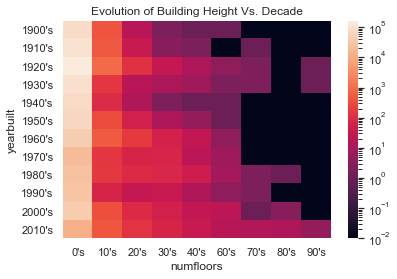

In [169]:
log_norm = LogNorm(vmin=df2.min().min(), vmax=df2.max().max())
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(df2.min().min())), 1+math.ceil(math.log10(df2.max().max())))]

sns.heatmap(
    df2,
    norm=log_norm,
    cbar_kws={"ticks": cbar_ticks}
).set_title("Evolution of Building Height Vs. Decade")

#Ideas from:
#https://stackoverflow.com/questions/36898008/seaborn-heatmap-with-logarithmic-scale-colorbar

## Part 2: Datashader

Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.

As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [5]:
yearbins = 200
floorbins = 200

yearBuiltCut = pd.cut(ny['yearbuilt'], np.linspace(ny['yearbuilt'].min(), ny['yearbuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['numfloors'], np.logspace(1, np.log(ny['numfloors'].max()), floorbins))

xlabels = np.floor(np.linspace(ny['yearbuilt'].min(), ny['yearbuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['numfloors'].max()), floorbins))

fig = go.FigureWidget(
    data = [
        go.Heatmap(z = ny.groupby([numFloorsCut, yearBuiltCut])['bbl'].count().unstack().fillna(0).values,
              colorscale = 'Greens', x = xlabels, y = ylabels)
    ]
)

fig

FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(247,252,245)'], [0.125,
                             'r…

This shows us the distribution, but it's subject to some biases discussed in the Anaconda notebook [Plotting Perils](https://anaconda.org/jbednar/plotting_pitfalls/notebook). 

Here is what the same plot would look like in datashader:



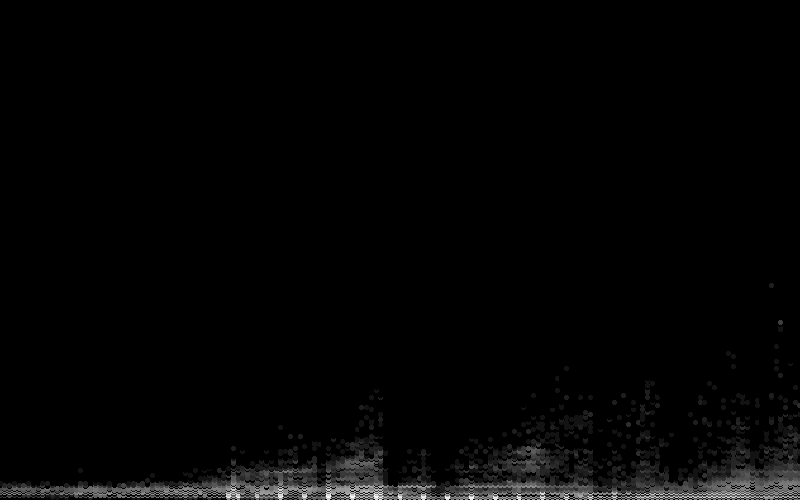

In [73]:
cvs = ds.Canvas(800, 500, x_range = (ny['yearbuilt'].min(), ny['yearbuilt'].max()), 
                                y_range = (ny['numfloors'].min(), ny['numfloors'].max()))
agg = cvs.points(ny, 'yearbuilt', 'numfloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

That's technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions.

Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:

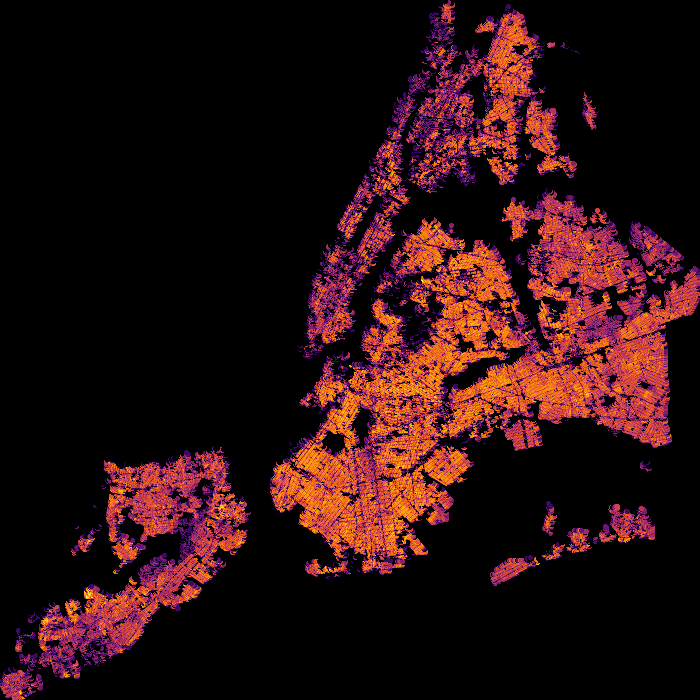

In [74]:
NewYorkCity   = (( 913164.0,  1067279.0), (120966.0, 272275.0))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'xcoord', 'ycoord')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes.

Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their [github repo](https://github.com/bokeh/datashader/tree/master/examples). I would focus on the [visualization pipeline](https://anaconda.org/jbednar/pipeline/notebook) and the [US Census](https://anaconda.org/jbednar/census/notebook) Example for the question below. Feel free to use my samples as templates as well when you work on this problem.

### Question

You work for a real estate developer and are researching underbuilt areas of the city. After looking in the [Pluto data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=17v1_1), you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about [bivariate choropleth maps](http://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/), and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

How can we decide where in NY are underdeveloped sites where someone could invest money and build something larger and more valuable than whatever exist at the moment. I decided to find just 1 number to guide this decision. This number is difference between the total assesment of the site minus the assessent of the land divided by the area of the lot. I believe that this is the adjusted value per square feet of a lot.
The code below does not show a bivariate choropleth. It only shows a simple choropleth coded to show the lot location in either of 3 colors: Blue, Green or Red. Blue is a low adjusted lot area price, red a high area price and green a midway point between these two extrema.

In the map bellow, red matches Manhattan and gentrified in Brooklyn. Green matches areas in Queens close to the city.  Blue matches farther from Manhattan Queen's regions.

I live in Flushing, a blue area according to my map, and I see the high rate of redevelopment of old residential and commercial lots. 

In [163]:
ny.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
ny['Built_Indicator'] = (ny['assesstot']-ny['assessland'])/ny['lotarea'] 

In [150]:
ny['Built_Indicator'].describe()

count    8.116840e+05
mean     5.495631e+01
std      1.233111e+03
min      0.000000e+00
25%      8.211987e+00
50%      1.370000e+01
75%      2.880000e+01
max      1.095790e+06
Name: Built_Indicator, dtype: float64

In [164]:
import matplotlib.pyplot as plt
import statistics
ny.B_I_Code.loc[(ny['Built_Indicator'] > 0) & (ny['Built_Indicator'] < 13.7)] = "A"
ny.B_I_Code.loc[(ny['Built_Indicator'] >= 13.7) & (ny['Built_Indicator'] < (13.7*4))] = "B"
ny.B_I_Code.loc[(ny['Built_Indicator'] >= (13.7*4)) & (ny['Built_Indicator'] < 200000000000000)] = "C"

In [156]:
indexNames = ny[ (ny['B_I_Code'] != 'A') & (ny['B_I_Code'] != 'B') & (ny['B_I_Code'] != 'C')].index
ny.drop(indexNames , inplace=True)
ny['B_I_Code'].value_counts()

A    403310
B    279060
C    126819
Name: B_I_Code, dtype: int64

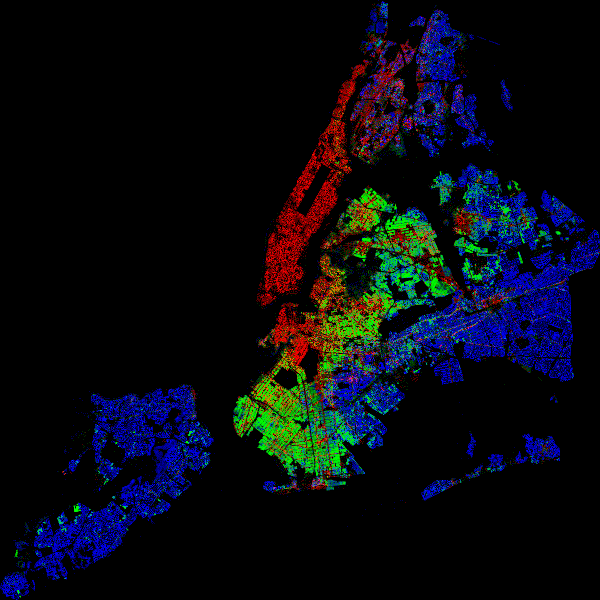

In [162]:
ny['B_I_Code'] = ny['B_I_Code'].astype('category')
color_key = {'A':'blue', 'B':'green',  'C':'red'}
cvs = ds.Canvas()
agg = cvs.points(ny, 'xcoord', 'ycoord', ds.count_cat('B_I_Code'))
cvs = ds.Canvas()
agg = cvs.points(ny, 'xcoord', 'ycoord', ds.count_cat('B_I_Code'))
export(tf.shade(agg, color_key = color_key, how = 'eq_hist'), 'export')*2